# Import Libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
import seaborn as sns

# Import Dataset

In [25]:
datasetFolderPath = r'/Users/boonsuenoh/Documents/Dev/product-recommendation-system/dataset/'

In [27]:
products = pd.read_json(datasetFolderPath + 'subset_meta_Electronics.json', lines=True)

In [28]:
products.head(10)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Electronics, Camera &amp; Photo, Video Survei...",,[The following camera brands and models have b...,,Genuine Geovision 1 Channel 3rd Party NVR IP S...,[],,GeoVision,"[Genuine Geovision 1 Channel NVR IP Software, ...","[>#3,092 in Tools &amp; Home Improvement &gt; ...",[],Camera &amp; Photo,,"January 28, 2014",$65.00,0011300000,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,"[Electronics, Camera &amp; Photo]",,[This second edition of the Handbook of Astron...,,"Books ""Handbook of Astronomical Image Processi...",[0999470906],,33 Books Co.,[Detailed chapters cover these fundamental top...,"[>#55,933 in Camera &amp; Photo (See Top 100 i...","[0943396670, 1138055360, 0999470906]",Camera &amp; Photo,,"June 17, 2003",,0043396828,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,"[Electronics, eBook Readers &amp; Accessories,...",,[A zesty tale. (Publishers Weekly)<br /><br />...,,One Hot Summer,"[0425167798, 039914157X]",,Visit Amazon's Carolina Garcia Aguilera Page,[],"3,105,177 in Books (",[],Books,,,$11.49,0060009810,[],[],NaN
3,"[Electronics, eBook Readers & Accessories, eBo...",,[],,Hurray for Hattie Rabbit: Story and pictures (...,"[0060219521, 0060219580, 0060219394]",,Visit Amazon's Dick Gackenbach Page,[],"2,024,298 in Books (","[0060219521, 0060219475, 0060219394]",Books,,,.a-section.a-spacing-mini{margin-bottom:6px!im...,0060219602,[],[],NaN
4,"[Electronics, eBook Readers & Accessories, eBo...",,[&#8220;sex.lies.murder.fame. is brillllli&#82...,,sex.lies.murder.fame.: A Novel,[],,Visit Amazon's Lolita Files Page,[],"3,778,828 in Books (",[],Books,,,$13.95,0060786817,[],[],NaN
5,"[Electronics, eBook Readers &amp; Accessories,...",,"[, ]",,College Physics,"[0073049557, 0134454170, 1118142063, 007733968...",,Visit Amazon's Alan Giambattista Page,[],"3,330,771 in Books (","[0073512141, 0077339681, 0073049557, 007304956...",Books,,,,0070524076,[],[],NaN
6,"[Electronics, eBook Readers & Accessories, eBo...",,[GIRL WITH A ONE-TRACK MIND: CONFESSIONS OF TH...,,Girl with a One-track Mind: Confessions of the...,[0330509691],,ABBY LEE,[],"3,304,037 in Books (",[B0719LDQR1],Books,,,$4.76,0091912407,[],[],NaN
7,"[Electronics, Portable Audio & Video, MP3 & MP...",,[Support system: Windows XP/Vsita/7 * SNR: 85d...,,abcGoodefg&reg; 4GB USB 2.0 Mp3 Music Player w...,"[B01NAJ3KQB, B00WYSPT0C, B00AF40U5G, B00OFVNM4...",,Crazy Cart,[Package Content: 1 x Display MP3 Player 1 x E...,"[>#177,454 in Electronics (See Top 100 in Elec...","[B01NAJ3KQB, B00OFVNM4G, B00L41WY8K, B07F34PNP...",All Electronics,"class=""a-bordered a-horizontal-stripes a-spa...","December 28, 2012",,0101635370,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
8,"[Electronics, Headphones, Earbud Headphones]",,"[, <b>True High Definition Sound:</b><br>With ...",,Wireless Bluetooth Headphones Earbuds with Mic...,[],,Enter The Arena,[Superb Sound Quality: Plays crystal clear aud...,[>#950 in Cell Phones & Accessories (See Top 1...,[],Home Audio & Theater,,"October 23, 2017",$7.99,0132492776,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
9,"[Electronics, Computers &amp; Accessories, Com...",,[],,Kelby Training DVD: Mastering Blend Modes in A...,[],,Kelby Training,[],"[>#932,732 in Computers &amp; Accessories &gt;...",[],Computers,,"December 9, 2011",,0132793040,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


In [29]:
print(products.shape)

(104802, 19)


## Remove unimportant columns

In [55]:
products = products.drop(columns=['fit', 'rank', 'details', 'tech1', 'tech2', 'price', 'date', 'also_buy', 'imageURL', 'imageURLHighRes', 'also_view', 'similar_item'], errors='ignore')
products.head(50)

,category,description,title,brand,feature,main_cat,asin
0,"[Electronics, Camera &amp; Photo, Video Survei...",[The following camera brands and models have b...,Genuine Geovision 1 Channel 3rd Party NVR IP S...,GeoVision,"[Genuine Geovision 1 Channel NVR IP Software, ...",Camera &amp; Photo,0011300000
1,"[Electronics, Camera &amp; Photo]",[This second edition of the Handbook of Astron...,"Books ""Handbook of Astronomical Image Processi...",33 Books Co.,[Detailed chapters cover these fundamental top...,Camera &amp; Photo,0043396828
2,"[Electronics, eBook Readers &amp; Accessories,...",[A zesty tale. (Publishers Weekly)<br /><br />...,One Hot Summer,Visit Amazon's Carolina Garcia Aguilera Page,[],Books,0060009810
3,"[Electronics, eBook Readers & Accessories, eBo...",[],Hurray for Hattie Rabbit: Story and pictures (...,Visit Amazon's Dick Gackenbach Page,[],Books,0060219602
4,"[Electronics, eBook Readers & Accessories, eBo...",[&#8220;sex.lies.murder.fame. is brillllli&#82...,sex.lies.murder.fame.: A Novel,Visit Amazon's Lolita Files Page,[],Books,0060786817
5,"[Electronics, eBook Readers &amp; Accessories,...","[, ]",College Physics,Visit Amazon's Alan Giambattista Page,[],Books,0070524076
6,"[Electronics, eBook Readers & Accessories, eBo...",[GIRL WITH A ONE-TRACK MIND: CONFESSIONS OF TH...,Girl with a One-track Mind: Confessions of the...,ABBY LEE,[],Books,0091912407
7,"[Electronics, Portable Audio & Video, MP3 & MP...",[Support system: Windows XP/Vsita/7 * SNR: 85d...,abcGoodefg&reg; 4GB USB 2.0 Mp3 Music Player w...,Crazy Cart,[Package Content: 1 x Display MP3 Player 1 x E...,All Electronics,0101635370
8,"[Electronics, Headphones, Earbud Headphones]","[, <b>True High Definition Sound:</b><br>With ...",Wireless Bluetooth Headphones Earbuds with Mic...,Enter The Arena,[Superb Sound Quality: Plays crystal clear aud...,Home Audio & Theater,0132492776
9,"[Electronics, Computers &amp; Accessories, Com...",[],Kelby Training DVD: Mastering Blend Modes in A...,Kelby Training,[],Computers,0132793040


In [56]:
# print(list(dict.fromkeys(products['details'].tolist())))

### Load a into new json file

In [59]:
products.to_json(datasetFolderPath + 'subset_meta_Electronics_cleansed.json')

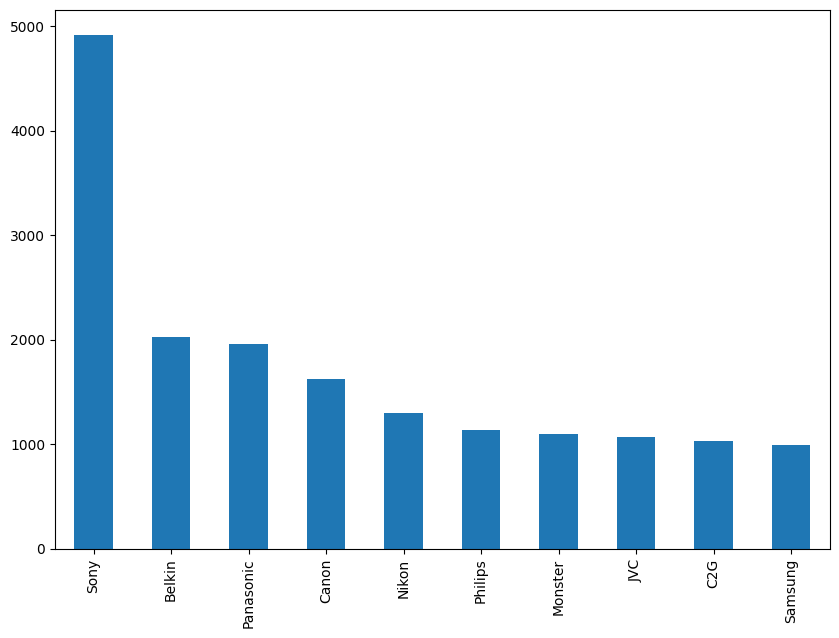

In [60]:
# Most frequent brands
plt.subplots(figsize=(10,7))
products.brand.value_counts()[:10].plot(kind="bar")
plt.show()

# Content Based Filtering Recommender System